In [82]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import dataframe_image as dfi
import requests
import hopsworks
import joblib
import os
%load_ext dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [2]:
%dotenv -vo .env

In [3]:
# TODO: runs local only, add (daily) modal function export/creation

In [4]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5300


Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# get feature group
# TODO: we could also just read the feature view but that doesn't include the
#  date of the latest entry. Shouldn't be a problem if both run on the same day
#  but just to be sure we'll get the complete entry from the group (see below).
feature_group = fs.get_feature_group(name="ny_elec", version=1)
display(feature_group.show(5))

2023-01-12 18:14:29,809 INFO: USE `iris_featurestore`
2023-01-12 18:14:30,266 INFO: SELECT `fg0`.`date` `date`, `fg0`.`temperature` `temperature`, `fg0`.`demand` `demand`, `fg0`.`day` `day`, `fg0`.`month` `month`, `fg0`.`holiday` `holiday`
FROM `iris_featurestore`.`ny_elec_1` `fg0`


,date,temperature,demand,day,month,holiday
0,2017-06-25,25.7,441658,6,6,0
1,2019-07-17,30.8,600695,2,7,0
2,2020-04-04,10.9,328054,5,4,0
3,2019-10-16,15.8,387485,2,10,0
4,2019-11-21,7.4,409803,3,11,0


In [6]:
# model
mr = project.get_model_registry()
model = mr.get_model("ny_elec_model", version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/ny_elec_model.pkl")

Connected. Call `.close()` to terminate connection gracefully.

In [7]:
offset = 1
X_pred = feature_group.read().tail(offset)
display(X_pred)

2023-01-12 18:14:53,303 INFO: USE `iris_featurestore`
2023-01-12 18:14:53,814 INFO: SELECT `fg0`.`date` `date`, `fg0`.`temperature` `temperature`, `fg0`.`demand` `demand`, `fg0`.`day` `day`, `fg0`.`month` `month`, `fg0`.`holiday` `holiday`
FROM `iris_featurestore`.`ny_elec_1` `fg0`


,date,temperature,demand,day,month,holiday
1828,2023-01-10,5.1,427763,1,1,0


In [8]:
# predict and get latest (daily) feature
y_pred = model.predict(X_pred.drop(columns=['demand', 'date']))
display(y_pred)

array([434581.22], dtype=float32)

In [9]:
prediction_date = X_pred.iloc[0]['date']
prediction_date = prediction_date.date()
display(prediction_date)

datetime.date(2023, 1, 10)

In [10]:
# get demand (forecast)
url = ('https://api.eia.gov/v2/electricity/rto/daily-region-data/data/'
       '?frequency=daily'
       '&data[0]=value'
       '&facets[respondent][]=NY'
       '&facets[timezone][]=Eastern'
       '&facets[type][]=DF'
       '&sort[0][column]=period'
       '&sort[0][direction]=desc'
       '&offset=0'
       '&length=5000')

url = url + '&start={}&end={}&api_key={}'.format(prediction_date, prediction_date, os.environ.get('EIA_API_KEY'))

In [11]:
data = requests.get(url).json()['response']['data']

In [12]:
display(data)

[{'period': '2023-01-10',
  'respondent': 'NY',
  'respondent-name': 'New York',
  'type': 'DF',
  'type-name': 'Day-ahead demand forecast',
  'timezone': 'Eastern',
  'timezone-description': 'Eastern',
  'value': 414410,
  'value-units': 'megawatthours'}]

In [13]:
forecast = data[0]['value']
display(forecast)
display(X_pred.iloc[0]['demand'])
display(y_pred[0])

414410

427763

434581.22

In [14]:
# DF for monitoring data
now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
data = {
    'prediction': y_pred,
    'actual': [X_pred.iloc[0]['demand']],
    'forecast_eia': [forecast],
    'prediction_date': [prediction_date],
    'datetime': [now],
}
monitor_df = pd.DataFrame(data)
display(monitor_df)

,prediction,actual,forecast_eia,prediction_date,datetime
0,434581.21875,427763,414410,2023-01-10,"01/12/2023, 18:14:57"


In [15]:
# create monitoring FG
monitor_fg = fs.get_or_create_feature_group(name="ny_elec_predictions",
                                            version=1,
                                            primary_key=["datetime"],
                                            description="NY Electricity Prediction/Outcome Monitoring")

monitor_fg.insert(monitor_df, write_options={"wait_for_job": False})

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/5300/jobs/named/ny_elec_predictions_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x1e7ebfaf880>, None)

In [19]:
history_df = monitor_fg.read()
# Add our prediction to the history, as the history_df won't have it -
# the insertion was done asynchronously, so it will take ~1 min to land on App
# TODO: commented for now since we can wait in a notebook, remember to uncomment
#  if running e.g. in a modal job!
#history_df = pd.concat([history_df, monitor_df])
display(history_df)

2023-01-12 18:15:54,047 INFO: USE `iris_featurestore`
2023-01-12 18:15:54,592 INFO: SELECT `fg0`.`prediction` `prediction`, `fg0`.`actual` `actual`, `fg0`.`forecast_eia` `forecast_eia`, `fg0`.`prediction_date` `prediction_date`, `fg0`.`datetime` `datetime`
FROM `iris_featurestore`.`ny_elec_predictions_1` `fg0`


,prediction,actual,forecast_eia,prediction_date,datetime
0,405542.53,395100,385451,2023-01-05,"01/07/2023, 14:16:12"
1,434039.75,419995,408753,2023-01-09,"01/11/2023, 12:36:56"
2,434581.22,427763,414410,2023-01-10,"01/12/2023, 18:14:57"


In [20]:
# MAE
y_pred = history_df['prediction']
y_test = history_df['actual']
mean_error = mean_absolute_error(y_test, y_pred)
display(mean_error) # in MWh
# TODO: compute "live" in UI

10435.166666666666

In [21]:
# create "recents" table for UI and upload
dataset_api = project.get_dataset_api()
dfi.export(history_df.tail(5), './df_ny_elec_recent.png', table_conversion='matplotlib')
dataset_api.upload("./df_ny_elec_recent.png", "Resources/images", overwrite=True)

Uploading: 0.000%|          | 0/37048 elapsed<00:00 remaining<?

'Resources/images/df_ny_elec_recent.png'

Uploading: 0.000%|          | 0/24418 elapsed<00:00 remaining<?

'Resources/images/df_ny_elec_prediction.png'

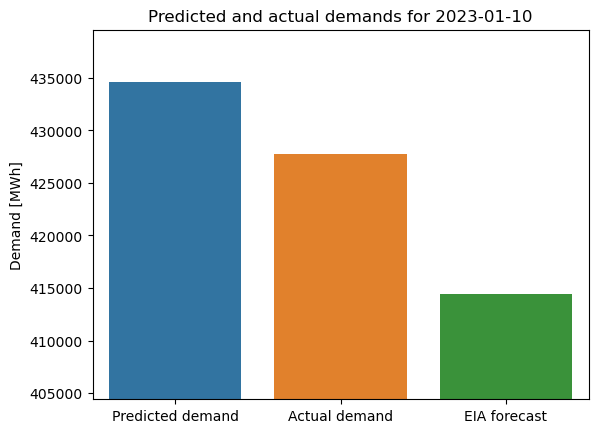

In [77]:
# create "prediction" chart for UI and upload
data = {'label': ['Predicted demand', 'Actual demand', 'EIA forecast'],
        'value': [monitor_df[l][0] for l in ['prediction', 'actual', 'forecast_eia']]}
pred_df = pd.DataFrame(data)
pred_plot = sns.barplot(data=pred_df, y='value', x='label')
plt.ylabel('Demand [MWh]')
plt.xlabel('')
plt.ylim(pred_df['value'].min() - 10000, pred_df['value'].max() + 5000)
plt.title('Predicted and actual demands for {}'.format(monitor_df['prediction_date'][0]))
fig = pred_plot.get_figure()
fig.savefig("./df_ny_elec_prediction.png")
dataset_api.upload("./df_ny_elec_prediction.png", "Resources/images", overwrite=True)

,prediction,actual,forecast_eia,prediction_date,datetime
0,405542.53,395100,385451,2023-01-05,"01/07/2023, 14:16:12"
1,434039.75,419995,408753,2023-01-09,"01/11/2023, 12:36:56"
2,434581.22,427763,414410,2023-01-10,"01/12/2023, 18:14:57"


,Prediction,EIA forecast,Date
0,10442.530000,9649.000000,2023-01-07
1,12243.640000,10445.500000,2023-01-11
2,10435.166667,11414.666667,2023-01-12


Uploading: 0.000%|          | 0/38495 elapsed<00:00 remaining<?

'Resources/images/df_ny_elec_mae.png'

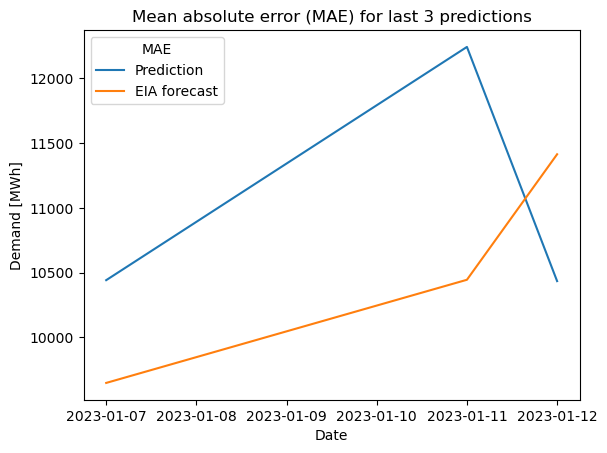

In [114]:
# create MAE trend graph for UI and upload
latest_history_df = history_df.loc[-5:] # TODO: might want/need to change this somewhen
display(latest_history_df)
no_entries = len(latest_history_df)
mae = []
for i in range(no_entries):
    df = latest_history_df.loc[:i]
    mae.append([mean_absolute_error(df['actual'], df['prediction']),
                mean_absolute_error(df['actual'], df['forecast_eia']),
                pd.to_datetime(df['datetime'][i]).date()])
mae_df = pd.DataFrame(mae, columns=['Prediction', 'EIA forecast', 'Date'])
display(mae_df)

mae_plot = sns.lineplot(data=mae_df.melt(id_vars=['Date'],
                                         value_vars=['Prediction', 'EIA forecast']),
                        x='Date', y='value', hue='variable')
plt.ylabel('Demand [MWh]')
plt.title('Mean absolute error (MAE) for last {} predictions'.format(no_entries))
mae_plot.legend().set_title('MAE')
fig = mae_plot.get_figure()
fig.savefig("./df_ny_elec_mae.png")
dataset_api.upload("./df_ny_elec_mae.png", "Resources/images", overwrite=True)